# Plot Error Distribution

In [8]:
%%time
import sys
sys.path.append('../python/')
import seaborn as sns
import json
import pandas as pd
from reconstruction_evaluation import load_preprocessed_reconstruction_or_from_cache, calculate_error
import numpy as np
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error

# To Reload the data
#!rm -Rf processed-evaluation-results.json

def load_data_for_approach(corpus, approach):
    field_to_use = 'actual'
    
    if 'MinResiduals' == approach:
        approach = 'Residuals'
        field_to_use = 'lower'
    if 'MaxResiduals' == approach:
        approach = 'Residuals'
        field_to_use = 'upper'
    
    ground_truth = []
    actual = []
    
    for _, i in dfs[corpus][dfs[corpus]['approach'] == approach].iterrows():
        for topic_data in i['topic_data']:
            ground_truth += [topic_data['ground_truth']]
            actual += [topic_data['prediction'][field_to_use]]
    
    return ground_truth, actual

def p_value(ground_truth, a, b):
    # we apply only the squared part because the root mean part is what happens later for the aggregation
    if len(ground_truth) != len(a) or len(a) != len(b):
        raise ValueError('Incompatible lengths...')
        
    a_squared_error = []
    b_squared_error = []
    
    for i in range(len(ground_truth)):
        a_squared_error += [pow(a[i] - ground_truth[i], 2)]
        b_squared_error += [pow(b[i] - ground_truth[i], 2)]
    
    _, p = ttest_ind(a_squared_error, b_squared_error)
    
    return p

def error_distribution(min_value, max_value, actual, predicted, normalized):
    ret = []
    
    if len(min_value) != len(max_value) or len(min_value) != len(actual) or len(min_value) != len(predicted):
        raise ValueError('Incompatible lengths...')
    
    for i in range(len(actual)):
        ret += [calculate_error(min_value[i], max_value[i], actual[i], predicted[i], normalized)]
    
    return ret

def load_result_df(corpus):
    ret = []
    
    _, actual_min_residuals = load_data_for_approach(corpus, 'MinResiduals')
    _, actual_condensed = load_data_for_approach(corpus, 'Condensed')
    _, actual_max_residuals = load_data_for_approach(corpus, 'MaxResiduals')
    
    for approach in ['MinResiduals', 'MaxResiduals', 'Condensed', 'PBS-R-ML', 'PBS-P-ML', 'PBS-RP-ML',
                     'Min-PBS-R-75', 'Min-PBS-P-75', 'Min-PBS-RP-75', 'Min-PBS-R-90', 'Min-PBS-P-90', 'Min-PBS-RP-90', 'Min-PBS-R-95', 'Min-PBS-P-95', 'Min-PBS-RP-95']:
        ground_truth, actual = load_data_for_approach(corpus, approach)

        ret += [{
            'Approach': approach,
            'Corpus': corpus,
            'Lower': mean_squared_error(ground_truth, np.maximum(actual, ground_truth), squared=False),
            
            'Lower (P Value To MinResiduals)': p_value(ground_truth, np.maximum(actual, ground_truth), np.maximum(actual_min_residuals, ground_truth)),
            'Lower (P Value To Condensed)': p_value(ground_truth, np.maximum(actual, ground_truth), np.maximum(actual_condensed, ground_truth)),
            'Lower (P Value To MaxResiduals)': p_value(ground_truth, np.maximum(actual, ground_truth), np.maximum(actual_max_residuals, ground_truth)),
            
            'Actual': mean_squared_error(ground_truth, actual, squared=False),
            
            'Actual (P Value To MinResiduals)': p_value(ground_truth, actual, actual_min_residuals),
            'Actual (P Value To Condensed)': p_value(ground_truth, actual, actual_condensed),
            'Actual (P Value To MaxResiduals)': p_value(ground_truth, actual, actual_max_residuals),
            
            'Upper': mean_squared_error(ground_truth, np.minimum(actual, ground_truth), squared=False),
            
            'Upper (P Value To MinResiduals)': p_value(ground_truth, np.minimum(actual, ground_truth), np.minimum(actual_min_residuals, ground_truth)),
            'Upper (P Value To Condensed)': p_value(ground_truth, np.minimum(actual, ground_truth), np.minimum(actual_condensed, ground_truth)),
            'Upper (P Value To MaxResiduals)': p_value(ground_truth, np.minimum(actual, ground_truth), np.minimum(actual_max_residuals, ground_truth)),
            
            'Errors': error_distribution(actual_min_residuals, actual_max_residuals, ground_truth, actual, False),
            'Errors (Normalized)': error_distribution(actual_min_residuals, actual_max_residuals, ground_truth, actual, True),
            
        }]

    return pd.DataFrame(ret)

df = pd.concat([load_result_df('Robust04'), load_result_df('CW09'), load_result_df('CW12')])

# Verify that the structure of the table is as expected.
df.head(2)

dfs = load_preprocessed_reconstruction_or_from_cache()

def load_errors(approach, corpus, normalized):
    ret = df[(df['Approach'] == approach) & (df['Corpus'] == corpus)]
    if len(ret) != 1:
        raise ValueError('TBD')
    
    ret = ret.iloc[0].to_dict()
    
    if normalized:
        return ret['Errors (Normalized)']
    else:
        return ret['Errors']
    

out = {'Condensed': {}, 'PBS-RP-ML': {}}

for k in list(out.keys()):
    out[k] = {
        'Robust04': load_errors(k, 'Robust04', False),
        'Robust04 (Normalized)': load_errors(k, 'Robust04', True),

        'CW09': load_errors(k, 'CW09', False),
        'CW09 (Normalized)': load_errors(k, 'CW09', True),

        'CW12': load_errors(k, 'CW12', False),
        'CW12 (Normalized)': load_errors(k, 'CW12', True),
    }
    
json.dump(out, open('tmp-errors.json', 'w'))

def load_error_df(normalized=True):
    df_errors = []
    errors = json.load(open('tmp-errors.json', 'r'))

    for k in errors.keys():
        for corpus in errors[k].keys():
            if normalized and 'normalized' in corpus.lower():
                for err in errors[k][corpus]:
                    df_errors += [{'Error': err, 'Corpus': corpus.split()[0], 'Normalized': normalized, 'Prediction': k}]
            elif not normalized and 'normalized' not in corpus.lower():
                for err in errors[k][corpus]:
                    df_errors += [{'Error': err, 'Corpus': corpus.split()[0], 'Normalized': normalized, 'Prediction': k}]
    
    return pd.DataFrame(df_errors)

CPU times: user 4.26 s, sys: 424 ms, total: 4.69 s
Wall time: 4.84 s


In [9]:
load_error_df(False).describe()

,Error
count,23372.000000
mean,-0.011256
std,0.069784
min,-0.576669
25%,-0.028821
50%,0.000000
75%,0.000000
max,0.441361


In [10]:
load_error_df(True).describe()

,Error
count,23372.000000
mean,-0.201506
std,0.537159
min,-1.000000
25%,-0.878264
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
pd.concat([load_error_df(True), load_error_df(False)])

,Error,Corpus,Normalized,Prediction
0,0.000000,Robust04,True,Condensed
1,0.000000,Robust04,True,Condensed
2,0.000000,Robust04,True,Condensed
3,0.000000,Robust04,True,Condensed
4,0.000000,Robust04,True,Condensed
...,...,...,...,...
23367,-0.022563,CW12,False,PBS-RP-ML
23368,0.000825,CW12,False,PBS-RP-ML
23369,0.001082,CW12,False,PBS-RP-ML
23370,0.000000,CW12,False,PBS-RP-ML


In [12]:
load_error_df(True)

,Error,Corpus,Normalized,Prediction
0,0.000000,Robust04,True,Condensed
1,0.000000,Robust04,True,Condensed
2,0.000000,Robust04,True,Condensed
3,0.000000,Robust04,True,Condensed
4,0.000000,Robust04,True,Condensed
...,...,...,...,...
23367,-0.325992,CW12,True,PBS-RP-ML
23368,0.002715,CW12,True,PBS-RP-ML
23369,0.003560,CW12,True,PBS-RP-ML
23370,0.000000,CW12,True,PBS-RP-ML


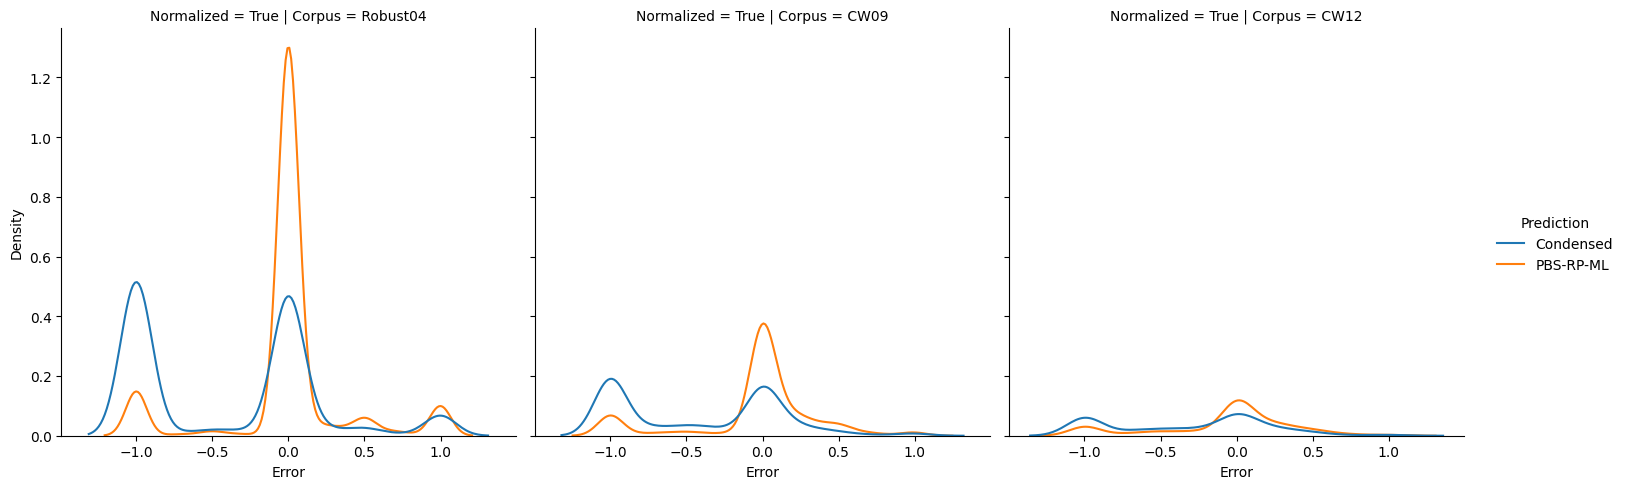

In [16]:
plot = sns.displot(data=load_error_df(True), x='Error', col='Corpus', hue='Prediction', kind='kde', row='Normalized')

plot.savefig('plot-error-distribution.pdf')
plot

In [8]:
def normaltest(x, alpha = 1e-3):
    from scipy import stats
    _, p = stats.normaltest(x)
    
    if p < alpha:
        print('The null hypothesis that x comes from a normal distribution can be rejected')
    else:
        print("The null hypothesis that x comes from a normal distribution cannot be rejected")

    return p

for method in ['PBS-RP-ML', 'Condensed']:
    for normalization in [True, False]:
        df = load_error_df()
        print('#'*50)
        print(method + ' With ' + ('normalization' if normalization else 'no normalization'))
        
        for corpus in ['Robust04', 'CW09', 'CW12']:
            print(normaltest(list(df[(df['Corpus'] == corpus) & (df['Prediction'] == method)]['Error'])))
        
        print('\n\n' + '#'*50)


##################################################
PBS-RP-ML With normalization
The null hypothesis that x comes from a normal distribution can be rejected
1.4002112542235747e-156
The null hypothesis that x comes from a normal distribution can be rejected
6.740039623493276e-128
The null hypothesis that x comes from a normal distribution can be rejected
4.921828670006092e-31


##################################################
##################################################
PBS-RP-ML With no normalization
The null hypothesis that x comes from a normal distribution can be rejected
1.4002112542235747e-156
The null hypothesis that x comes from a normal distribution can be rejected
6.740039623493276e-128
The null hypothesis that x comes from a normal distribution can be rejected
4.921828670006092e-31


##################################################
##################################################
Condensed With normalization
The null hypothesis that x comes from a normal distributi